<a href="https://colab.research.google.com/github/xelav/boosters-digital-reputation/blob/master/boosters_experiments_part1_randomsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

root_dir = "/content/drive/My Drive/boosters"
%cd "{root_dir}"
!pip install catboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/boosters


# Prapare data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.ensemble import VotingClassifier

from tqdm import tqdm
from catboost import CatBoostClassifier

import datetime
import json
import pickle
import copy

from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import cv as catboost_cv
from scipy import sparse

In [0]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

(8058, 214075)


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


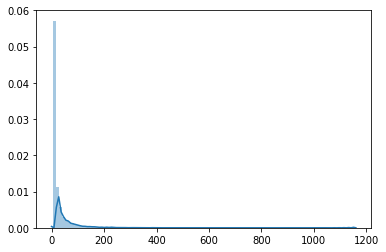

In [0]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    print((len(rows), len(cols)))
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    return X2, svd

X2_all = X2.append(X2_test)
X2_all, svd = transform_x2(X2_all)

X2 = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
X = X.drop('id', axis=1)
Y_cls = df.iloc[:, -5:]

X2_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_submit = df_test

In [0]:
X1.merge(X3, on='id').merge(Y, on='id').drop(['id'], axis=1).iloc[:, :-5]

In [0]:
params

{'bootstrap_type': 'No',
 'depth': 8,
 'grow_policy': 'Depthwise',
 'l2_leaf_reg': 7.562086195635377e-12,
 'learning_rate': 7.574292322913348e-05,
 'n_estimators': 1000,
 'random_state': 28446}

In [0]:
with open('best_params.pkl', mode='rb') as f:
    best_params = pickle.load(f)

In [0]:
params = copy.copy(best_params['1'])
params['n_estimators'] = 1000
params['l2_leaf_reg'] = 1e1
params['learning_rate'] = 0.1
params['depth'] = 2

clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                         early_stopping_rounds=100, loss_function='CrossEntropy', **params)

results = cross_validation_score_statement(clf,
                                X,
                                Y['1'],
                                roc_auc_score)
print(results)
print(results.mean())

0:	learn: 0.5996991	test: 0.5267773	best: 0.5267773 (0)	total: 18.2ms	remaining: 18.1s
50:	learn: 0.7431376	test: 0.5697254	best: 0.5849962 (7)	total: 815ms	remaining: 15.2s
100:	learn: 0.8094378	test: 0.5642716	best: 0.5849962 (7)	total: 1.55s	remaining: 13.8s
bestTest = 0.5849961638
bestIteration = 7
Shrink model to first 8 iterations.
0:	learn: 0.5811834	test: 0.5911883	best: 0.5911883 (0)	total: 15.9ms	remaining: 15.9s
50:	learn: 0.7507378	test: 0.5851886	best: 0.6062259 (6)	total: 814ms	remaining: 15.2s
100:	learn: 0.8095346	test: 0.5917667	best: 0.6062259 (6)	total: 1.48s	remaining: 13.2s
bestTest = 0.606225878
bestIteration = 6
Shrink model to first 7 iterations.
0:	learn: 0.5780914	test: 0.5439219	best: 0.5439219 (0)	total: 15.7ms	remaining: 15.6s
50:	learn: 0.7351575	test: 0.5625042	best: 0.5759851 (5)	total: 806ms	remaining: 15s
100:	learn: 0.7999225	test: 0.5557843	best: 0.5759851 (5)	total: 1.49s	remaining: 13.2s
bestTest = 0.575985074
bestIteration = 5
Shrink model to firs

In [0]:
target='1'

X_train, X_val, Y_train, Y_val = train_test_split(X.drop('id', axis=1), Y, test_size=0.3, random_state=42)

params = copy.copy(best_params[target])
# params['n_estimators'] = 100
# params['l2_leaf_reg'] = 1e1
# params['learning_rate'] = 0.1
# params['depth'] = 8

clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                         # early_stopping_rounds=100,
                         loss_function='CrossEntropy', **params)

cv_data = cv(Pool(X_train.values, label=Y_train[target].values),
             clf.get_params(), fold_count=5, verbose=False)
print(cv_data['test-AUC-mean'].max(), cv_data['test-AUC-std'].mean())


clf.fit(X_train.values, Y_train[target].values)

metrics = clf.eval_metrics(Pool(X_val.values, Y_val[target].values), ['AUC'])
np.array(metrics['AUC']).mean()

0.5825225114822388 0.015919121538480973
0:	learn: 0.6479750	total: 20.6ms	remaining: 4.1s
50:	learn: 0.7765669	total: 882ms	remaining: 2.58s
100:	learn: 0.7841402	total: 1.76s	remaining: 1.73s
150:	learn: 0.7862746	total: 2.65s	remaining: 861ms
199:	learn: 0.7869387	total: 3.43s	remaining: 0us


0.5682901579290133

# Best params validation

In [0]:
means, catboost_means = [], []
random_state = 42069666
models_dict = {i:[] for i in '12345'}

for target in tqdm('12345'):

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_iter = list(cv.split(X, Y))

    scores = []
    catboost_scores = []

    for train, test in tqdm(cv_iter):

        X_train, X_val, y_train, y_val = train_test_split(
            X.iloc[train, :].values, Y[target].iloc[train].values,
            test_size=0.2, random_state=random_state
            )
        X_test = X.iloc[test, :].values
        y_test = Y[target].iloc[test].values

        # cv_data = catboost_cv(Pool(X.iloc[train, :].values, label=Y[target].iloc[train].values),
        #         clf.get_params(), fold_count=5, verbose=False)
        # print('Catboost:   ', cv_data['test-AUC-mean'].max(), cv_data['test-AUC-std'].mean())
        # catboost_scores.append(cv_data['test-AUC-mean'].max())

        clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                                # early_stopping_rounds=100,
                                loss_function='CrossEntropy', **(best_params[target])
        )

        clf.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                use_best_model=True,
                )
        y_statement = Y[target].iloc[test]
        pred_statement = clf.predict_proba(X_test)[:, 1]
        scores.append(roc_auc_score(y_statement, pred_statement))
        models_dict[target].append(clf)

    # eclf = VotingClassifier(estimators=models, voting='soft')
    scores = np.array(scores)
    # catboost_scores = np.array(catboost_scores)
    print(scores, '\n', scores.mean())
    # print('\n', catboost_scores, '\n', catboost_scores.mean())

    means.append(scores.mean())
    # catboost_means.append(catboost_scores.mean())

  0%|          | 0/5 [00:00<?, ?it/s]

[0.60901211 0.57353827 0.58078516 0.56100169 0.55978818] 
 0.5768250827443612



  0%|          | 0/5 [00:00<?, ?it/s]

[0.54079665 0.59735493 0.58452556 0.58102489 0.58276171] 
 0.5772927481132214



  0%|          | 0/5 [00:00<?, ?it/s]

[0.61484096 0.62684113 0.61120708 0.59217226 0.63111351] 
 0.6152349886775662



  0%|          | 0/5 [00:00<?, ?it/s]

[0.60074066 0.53865623 0.61708445 0.59919391 0.58806296] 
 0.5887476402550718



100%|██████████| 5/5 [04:52<00:00, 61.36s/it]

[0.53757021 0.52826069 0.53058689 0.55842018 0.55615191] 
 0.5421979760490963


In [0]:
np.array(preds).mean(axis=0)

## Ensemble experiment


In [0]:
for i in '12345':
    preds = []
    for c in models_dict[i]:
        preds.append(clf.predict_proba(X.iloc[test, :].values)[:, 1])
    pred = np.array(preds).mean(axis=0)
    print(roc_auc_score(Y[i].iloc[test].values, pred))

0.5360620848292023
0.5191338755168543
0.5493793847814354
0.5583065257352942
0.55615191022637


In [0]:
probas = []
scores = []
for i in tqdm('12345'):
    preds = []
    for c in models_dict[i]:
        preds.append(clf.predict_proba(X_submit.values)[:, 1])
    proba = np.array(preds).mean(axis=0)
    probas += [proba]

filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_submit['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)

100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


0.500!


## a

In [0]:
probas = []
scores = []
for target in tqdm('12345'):

    X_train, X_val, y_train, y_val = train_test_split(
            X.values, Y[target].values,
            test_size=0.2, random_state=random_state
            )

    clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                                # early_stopping_rounds=100,
                                loss_function='CrossEntropy', **(best_params[target])
        )
    clf.fit(X_train, y_train, eval_set=(X_val, y_val))
    proba = clf.predict_proba(X_submit.values)[:, 1]
    probas += [proba]

filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_submit['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)

100%|██████████| 5/5 [00:59<00:00, 12.57s/it]


In [0]:
(baseline.drop('id', axis=1)>0.5).sum()

1     4
2    19
3     0
4    36
5     0
dtype: int64

In [0]:
models = []
probas = []
scores = []
for i in tqdm('12345'):
    clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                         early_stopping_rounds=100, loss_function='CrossEntropy', **params)
    clf.fit(X.values, Y_cls[i].values)
    proba = clf.predict_proba(X_test.values)[:, 1]
    probas += [proba]
    models.append(clf)

filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5016860	total: 11.2ms	remaining: 214ms
19:	learn: 0.6088406	total: 227ms	remaining: 0us


 20%|██        | 1/5 [00:01<00:07,  1.76s/it]

0:	learn: 0.5657551	total: 22.8ms	remaining: 433ms
19:	learn: 0.6108184	total: 209ms	remaining: 0us


 40%|████      | 2/5 [00:03<00:05,  1.73s/it]

0:	learn: 0.6026489	total: 9.78ms	remaining: 186ms
19:	learn: 0.6347770	total: 216ms	remaining: 0us


 60%|██████    | 3/5 [00:05<00:03,  1.71s/it]

0:	learn: 0.5034736	total: 9.38ms	remaining: 178ms
19:	learn: 0.6127180	total: 186ms	remaining: 0us


 80%|████████  | 4/5 [00:06<00:01,  1.69s/it]

0:	learn: 0.5053477	total: 9.34ms	remaining: 177ms
19:	learn: 0.6077222	total: 186ms	remaining: 0us


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


In [0]:
params = copy.copy(random_search_list[0].best_params_)
params['n_estimators'] = 1000
params['l2_leaf_reg'] = 1e1
params['learning_rate'] = 0.001
params['depth'] = 2

clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                         early_stopping_rounds=100, loss_function='CrossEntropy', **params)

results = cross_validation_score_statement(clf,
                                X.drop('id', axis=1),
                                Y['5'],
                                roc_auc_score)
print(results)
print(results.mean())

0:	learn: 0.5025728	test: 0.4977074	best: 0.4977074 (0)	total: 43.9ms	remaining: 43.9s
50:	learn: 0.6242287	test: 0.5662356	best: 0.5675108 (17)	total: 2.23s	remaining: 41.5s
100:	learn: 0.6461400	test: 0.5731235	best: 0.5775415 (92)	total: 4.35s	remaining: 38.7s
150:	learn: 0.6543615	test: 0.5657235	best: 0.5775415 (92)	total: 6.48s	remaining: 36.4s
bestTest = 0.5775414705
bestIteration = 92
Shrink model to first 93 iterations.
0:	learn: 0.5104288	test: 0.4917273	best: 0.4917273 (0)	total: 37.4ms	remaining: 37.3s
50:	learn: 0.6231074	test: 0.5332199	best: 0.5566695 (6)	total: 1.69s	remaining: 31.5s
100:	learn: 0.6534728	test: 0.5495548	best: 0.5566695 (6)	total: 3.41s	remaining: 30.4s
bestTest = 0.5566694587
bestIteration = 6
Shrink model to first 7 iterations.
0:	learn: 0.5008842	test: 0.5006971	best: 0.5006971 (0)	total: 33.4ms	remaining: 33.4s
50:	learn: 0.6154810	test: 0.5230956	best: 0.5258037 (20)	total: 1.73s	remaining: 32.2s
100:	learn: 0.6283248	test: 0.5217114	best: 0.527999

In [0]:
params = copy.copy(random_search_list[0].best_params_)
params['n_estimators'] = 1000
params['l2_leaf_reg'] = 1e1
params['learning_rate'] = 0.001
params['depth'] = 2

In [0]:


X_train, X_val, Y_train, Y_val = train_test_split(X.drop('id', axis=1), Y, test_size=0.2, random_state=42)

In [0]:


cv_data = cv(Pool(X_train.values, label=Y_train['1'].values), clf.get_params(), fold_count=5, verbose=True)
cv_data['test-AUC-mean'].max(), cv_data['test-AUC-std'].mean()

0:	test: 0.5474616	best: 0.5474616 (0)
1:	test: 0.5521059	best: 0.5521059 (1)
2:	test: 0.5465214	best: 0.5521059 (1)
3:	test: 0.5464178	best: 0.5521059 (1)
4:	test: 0.5476439	best: 0.5521059 (1)
5:	test: 0.5460523	best: 0.5521059 (1)
6:	test: 0.5467891	best: 0.5521059 (1)
7:	test: 0.5428771	best: 0.5521059 (1)
8:	test: 0.5430431	best: 0.5521059 (1)
9:	test: 0.5437539	best: 0.5521059 (1)
10:	test: 0.5432732	best: 0.5521059 (1)
Stopped by overfitting detector  (10 iterations wait)
11:	test: 0.5440353	best: 0.5521059 (1)	total: 31.3s	remaining: 42m 56s


(0.5521058529615402, 0.028228627020056175)

In [0]:
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                        early_stopping_rounds=10, loss_function='CrossEntropy', **params)
clf.fit(X_train2.values, Y_train2['1'].values, eval_set=(X_val2.values, Y_val2['1'].values))


0:	learn: 0.6073557	test: 0.5784798	best: 0.5784798 (0)	total: 16.1ms	remaining: 16.1s
bestTest = 0.5784798414
bestIteration = 0
Shrink model to first 1 iterations.


In [0]:
clf.eval_metrics(Pool(X_val.values, Y_val['1'].values), ['AUC'])

{'AUC': [0.5438966769772127]}

In [0]:
models = []
probas = []
scores = []
for i in tqdm('12345'):
    clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC",
                         early_stopping_rounds=100, loss_function='CrossEntropy', **params)
    clf.fit(X_train.drop('id', axis=1).values, Y_train[i].values,
            eval_set=(X_val.drop('id', axis=1).values, Y_val[i].values))
    proba = clf.predict_proba(X_test.values)[:, 1]
    probas += [proba]
    models.append(clf)

filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5042975	test: 0.5010251	best: 0.5010251 (0)	total: 41.7ms	remaining: 41.7s
50:	learn: 0.6315745	test: 0.5584473	best: 0.5584473 (50)	total: 2.13s	remaining: 39.7s
100:	learn: 0.6502818	test: 0.5554287	best: 0.5612603 (51)	total: 4.23s	remaining: 37.6s
150:	learn: 0.6619279	test: 0.5545347	best: 0.5612603 (51)	total: 6.29s	remaining: 35.4s
bestTest = 0.5612602532
bestIteration = 51
Shrink model to first 52 iterations.


 20%|██        | 1/5 [00:08<00:32,  8.04s/it]

0:	learn: 0.5761240	test: 0.5335197	best: 0.5335197 (0)	total: 33.8ms	remaining: 33.8s
50:	learn: 0.6369943	test: 0.5663144	best: 0.5668695 (47)	total: 1.71s	remaining: 31.8s
100:	learn: 0.6484135	test: 0.5684758	best: 0.5692320 (97)	total: 3.43s	remaining: 30.5s
150:	learn: 0.6517739	test: 0.5680005	best: 0.5692320 (97)	total: 5.27s	remaining: 29.6s
200:	learn: 0.6556353	test: 0.5771038	best: 0.5778114 (195)	total: 7.18s	remaining: 28.5s
250:	learn: 0.6570965	test: 0.5744637	best: 0.5778114 (195)	total: 9.09s	remaining: 27.1s
bestTest = 0.5778114498
bestIteration = 195
Shrink model to first 196 iterations.


 40%|████      | 2/5 [00:20<00:28,  9.44s/it]

0:	learn: 0.6073891	test: 0.5811117	best: 0.5811117 (0)	total: 33.7ms	remaining: 33.7s
50:	learn: 0.6628193	test: 0.5958482	best: 0.6019788 (30)	total: 1.78s	remaining: 33.2s
100:	learn: 0.6807356	test: 0.5938154	best: 0.6028782 (54)	total: 3.5s	remaining: 31.2s
150:	learn: 0.6886595	test: 0.6064004	best: 0.6072351 (144)	total: 5.24s	remaining: 29.4s
200:	learn: 0.6910170	test: 0.5970822	best: 0.6072351 (144)	total: 6.98s	remaining: 27.7s
bestTest = 0.6072351038
bestIteration = 144
Shrink model to first 145 iterations.


 60%|██████    | 3/5 [00:30<00:19,  9.67s/it]

0:	learn: 0.5029127	test: 0.4995668	best: 0.4995668 (0)	total: 35.2ms	remaining: 35.2s
50:	learn: 0.6552772	test: 0.6078740	best: 0.6115852 (23)	total: 1.76s	remaining: 32.7s
100:	learn: 0.6599142	test: 0.6086293	best: 0.6115852 (23)	total: 3.5s	remaining: 31.2s
bestTest = 0.6115852296
bestIteration = 23
Shrink model to first 24 iterations.


 80%|████████  | 4/5 [00:36<00:08,  8.53s/it]

0:	learn: 0.5018634	test: 0.5014965	best: 0.5014965 (0)	total: 38.2ms	remaining: 38.1s
50:	learn: 0.6330254	test: 0.5372802	best: 0.5416105 (23)	total: 1.74s	remaining: 32.4s
100:	learn: 0.6556971	test: 0.5506436	best: 0.5539650 (93)	total: 3.47s	remaining: 30.9s
150:	learn: 0.6533656	test: 0.5546151	best: 0.5549536 (145)	total: 5.18s	remaining: 29.1s
200:	learn: 0.6612288	test: 0.5513885	best: 0.5564806 (160)	total: 6.9s	remaining: 27.4s
250:	learn: 0.6623944	test: 0.5501696	best: 0.5564806 (160)	total: 8.66s	remaining: 25.8s
bestTest = 0.5564806163
bestIteration = 160
Shrink model to first 161 iterations.


100%|██████████| 5/5 [00:47<00:00,  9.19s/it]


In [0]:
params = copy.copy(random_search_list[0].best_params_)
params['n_estimators'] = 1000
clf = CatBoostClassifier(verbose=50, task_type="GPU", eval_metric="AUC", early_stopping_rounds=10, **params)

results = cross_validation_score_statement(clf,
                                X,
                                Y['1'],
                                roc_auc_score)
print(results)
print(results.mean())

0:	learn: 0.8709782	test: 0.5221815	best: 0.5221815 (0)	total: 44.4ms	remaining: 44.4s
bestTest = 0.5264035165
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.8501705	test: 0.5294383	best: 0.5294383 (0)	total: 39.1ms	remaining: 39.1s
bestTest = 0.5422465503
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.8614599	test: 0.5313472	best: 0.5313472 (0)	total: 41.2ms	remaining: 41.1s
bestTest = 0.5313471854
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.8127449	test: 0.5278667	best: 0.5278667 (0)	total: 36.1ms	remaining: 36s
bestTest = 0.5278667063
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.8395403	test: 0.5480137	best: 0.5480137 (0)	total: 43.7ms	remaining: 43.7s
bestTest = 0.5590091348
bestIteration = 2
Shrink model to first 3 iterations.
[0.52640351 0.54224656 0.53134719 0.5278667  0.55900913]
0.5373746170078253


# Random search

## Train

In [0]:
from scipy.stats import randint, uniform, logistic
from scipy.stats import uniform
import scipy as sp

from sklearn.model_selection import RandomizedSearchCV
import time

class log_uniform():        
    def __init__(self, a=-1, b=0, base=10):
        self.loc = a
        self.scale = b - a
        self.base = base

    def rvs(self, size=None, random_state=None):
        uniform = sp.stats.uniform(loc=self.loc, scale=self.scale)
        if size is None:
            return np.power(self.base, uniform.rvs(random_state=random_state))
        else:
            return np.power(self.base, uniform.rvs(size=size, random_state=random_state))

In [0]:
log_uniform(a=-6, b=2).rvs()

88.44027632090655

In [0]:
# specify parameters and distributions to sample from
param_dist = {"learning_rate":log_uniform(a=-4, b=0),
             'depth': [1,2,3,4],
             "l2_leaf_reg": log_uniform(a=-6, b=2),
              "random_state": randint(0, 2**16),
              "bootstrap_type": ['Bayesian', 'Bernoulli', 'No'],
              "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"],
             }

In [0]:
from sklearn.metrics import make_scorer

n_iter_search = 10

clf = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC", n_estimators=1000, early_stopping_rounds=100)

random_search_list = [RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, verbose=4,
                                   scoring=make_scorer(roc_auc_score))
                    for i in range(5)]

In [0]:
for i, search in tqdm(zip('12345', random_search_list)):
    print('\n\n',i,'\n\n')
    search.fit(X.values, Y[i].values)

In [0]:
with open('2.pkl', mode='wb') as f:
    pickle.dump(random_search_list, f)

In [0]:
with open('2.pkl', mode='rb') as f:
    random_search_list = pickle.load(f)

## Validation

In [0]:
def cross_validation_score_statement(estimator,
                                     X,
                                     y,
                                     scoring,
                                     n_splits=5,
                                     statement=None,
                                     random_state=0):
    """
    Evaluate a score by cross-validation. 
    The fit method will be performed on the entire train subset at each iteration,
    the predict method and scoring will be performed only for objects from test subset where statement is True
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : pandas.DataFrame
        The data to fit.
    y : pandas.Series
        The target variable to try to predict.
    scoring : callable 
        The scoring function of signature scoring(y_true,y_pred).
    statement : boolean numpy.array of shape equal to y.shape
        The mask showing the objects we want to evaluate estimator on.
    n_splits : int
        Number of folds for cross-validation
    random_state : int
        Random_state for KFold and StratifiedKFold    
    
    Returns
    -----------
    scores : array of float, shape=(n_splits,)
    
    """
    if statement is None:
        cv = KFold(n_splits=n_splits, shuffle=False, random_state=random_state)
        cv_iter = list(cv.split(X, y))
    else:
        cv = StratifiedKFold(n_splits=n_splits,
                             shuffle=True,
                             random_state=random_state)
        cv_iter = list(cv.split(X, statement))
    scores = []

    for train, test in cv_iter:
        estimator.fit(X.iloc[train, :].values, y.iloc[train].values,
                      eval_set=(X.iloc[test, :].values, y.iloc[test].values))
        if statement is not None:
            y_statement = y.iloc[test].loc[statement[test]]
            pred_statement = estimator.predict_proba(
                X.iloc[test, :].loc[statement[test]].values)[:, 1]
        else:
            y_statement = y.iloc[test]
            pred_statement = estimator.predict_proba(X.iloc[test, :].values)[:, 1]
        scores.append(scoring(y_statement, pred_statement))
    return np.array(scores)

In [0]:
def validate_params(params):
    print(f"Params: \n", params)
    means = []
    for i in tqdm("12345"):
        cls = CatBoostClassifier(verbose=False, eval_metric="AUC", task_type="GPU", **params)
        results = cross_validation_score_statement(cls, X, Y[i], roc_auc_score)
        print(results)
        print(results.mean())
        means.append(results.mean())
    print(np.array(means).mean())
    return(np.array(means))

In [0]:
n_best = 3
best_params = {}
best_results = {}
for target, random_search in tqdm(zip('12345', random_search_list)):
    
    val_results = []

    for random_search in tqdm(random_search_list):
        for i in range(n_best):
            params = random_search.cv_results_['params'][
                random_search.cv_results_['mean_test_score'].argsort()[i]
            ]

            cls = CatBoostClassifier(verbose=False, eval_metric="AUC", task_type="GPU", **params)
            results = cross_validation_score_statement(cls, X, Y[target], roc_auc_score)
            
            if best_results.get(target, 0) < results.mean():
                best_results[target] = results.mean()
                best_params[target] = params

In [0]:
means = []
for target in tqdm('12345'):
    cls = CatBoostClassifier(verbose=False, eval_metric="AUC", task_type="GPU", **(best_params[target]))
    results = cross_validation_score_statement(cls, X, Y[target], roc_auc_score)
    print(results)
    print(results.mean())
    means.append(results.mean())
print(np.array(means).mean())


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:22,  5.73s/it]

 40%|████      | 2/5 [00:10<00:16,  5.50s/it]

 60%|██████    | 3/5 [00:15<00:10,  5.39s/it]

 80%|████████  | 4/5 [00:20<00:05,  5.27s/it]

100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


 20%|██        | 1/5 [00:26<01:44, 26.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[0.58628528 0.60986449 0.58661685 0.59983669 0.60646151]
0.5978129622178597




 20%|██        | 1/5 [00:04<00:18,  4.67s/it]

 40%|████      | 2/5 [00:09<00:13,  4.65s/it]

 60%|██████    | 3/5 [00:13<00:09,  4.60s/it]

 80%|████████  | 4/5 [00:18<00:04,  4.66s/it]

100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


 40%|████      | 2/5 [00:49<01:15, 25.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[0.5810114  0.56347582 0.59744    0.60019919 0.6011279 ]
0.5886508614437869




 20%|██        | 1/5 [00:14<00:58, 14.61s/it]

 40%|████      | 2/5 [00:29<00:43, 14.61s/it]

 60%|██████    | 3/5 [00:43<00:29, 14.56s/it]

 80%|████████  | 4/5 [00:58<00:14, 14.55s/it]

100%|██████████| 5/5 [01:12<00:00, 14.51s/it]


 60%|██████    | 3/5 [02:01<01:18, 39.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[0.61597125 0.6071611  0.62462915 0.62133191 0.62352335]
0.6185233524601752




 20%|██        | 1/5 [00:14<00:57, 14.47s/it]

 40%|████      | 2/5 [00:28<00:43, 14.45s/it]

 60%|██████    | 3/5 [00:43<00:28, 14.46s/it]

 80%|████████  | 4/5 [00:57<00:14, 14.36s/it]

100%|██████████| 5/5 [01:11<00:00, 14.22s/it]


 80%|████████  | 4/5 [03:13<00:49, 49.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[0.60086055 0.611618   0.60059381 0.60024186 0.5988205 ]
0.6024269450471265




 20%|██        | 1/5 [00:14<00:58, 14.54s/it]

 40%|████      | 2/5 [00:29<00:43, 14.53s/it]

 60%|██████    | 3/5 [00:43<00:29, 14.52s/it]

 80%|████████  | 4/5 [00:57<00:14, 14.48s/it]

100%|██████████| 5/5 [01:12<00:00, 14.48s/it]


100%|██████████| 5/5 [04:25<00:00, 56.05s/it]


[0.564532   0.56623265 0.52703373 0.55555556 0.54955252]
0.5525812919599614
0.5919990826257819


## Predict

In [0]:
def make_predictions(param_dict):

    models = []
    probas = []
    scores = []
    for i in tqdm('12345'):
        cls = CatBoostClassifier(verbose=100, eval_metric="AUC", task_type="GPU", **(param_dict[i]))
        cls.fit(X.values, Y_cls[i].values)
        proba = cls.predict_proba(X_test.values)[:, 1]
        probas += [proba]
        models.append(cls)
    
    filename = '{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))

    tmp = pd.DataFrame(probas).T
    baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
    baseline['id'] = X_test['id']
    baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, index=False)

In [0]:
make_predictions(best_params)


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6248390	total: 22ms	remaining: 4.38s
100:	learn: 0.7422866	total: 1.82s	remaining: 1.79s
199:	learn: 0.7440557	total: 3.61s	remaining: 0us



 20%|██        | 1/5 [00:05<00:21,  5.32s/it]

0:	learn: 0.5888259	total: 16.3ms	remaining: 3.23s
100:	learn: 0.7011446	total: 1.35s	remaining: 1.32s
199:	learn: 0.7327906	total: 2.89s	remaining: 0us



 40%|████      | 2/5 [00:09<00:15,  5.07s/it]

0:	learn: 0.6342335	total: 66.9ms	remaining: 13.3s
100:	learn: 0.8137848	total: 6.83s	remaining: 6.7s
199:	learn: 0.8146306	total: 13.4s	remaining: 0us



 60%|██████    | 3/5 [00:24<00:16,  8.07s/it]

0:	learn: 0.6236946	total: 69.8ms	remaining: 13.9s
100:	learn: 0.8441024	total: 6.63s	remaining: 6.5s
199:	learn: 0.8525574	total: 13s	remaining: 0us



 80%|████████  | 4/5 [00:39<00:10, 10.05s/it]

0:	learn: 0.5555262	total: 66.8ms	remaining: 13.3s
100:	learn: 0.8899512	total: 6.78s	remaining: 6.65s
199:	learn: 0.8829651	total: 13.4s	remaining: 0us



100%|██████████| 5/5 [00:54<00:00, 11.54s/it]


In [0]:
import json
filename = '{}'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H%M"))
with open(f"{filename}-params.pkl", 'wb') as f:
    pickle.dump(best_params, f)

In [0]:
best_results, best_results.values()

({'1': 0.5987095931147902,
  '2': 0.5897032775437594,
  '3': 0.6185233524601752,
  '4': 0.6024269450471265,
  '5': 0.5525812919599614},
 dict_values([0.5987095931147902, 0.5897032775437594, 0.6185233524601752, 0.6024269450471265, 0.5525812919599614]))

In [0]:
best_params

{'1': {'bootstrap_type': 'Bernoulli',
  'depth': 4,
  'grow_policy': 'Depthwise',
  'l2_leaf_reg': 3.4911467509339033e-12,
  'learning_rate': 5.440921160038629e-05,
  'n_estimators': 200,
  'random_state': 24568},
 '2': {'bootstrap_type': 'Bayesian',
  'depth': 3,
  'grow_policy': 'Lossguide',
  'l2_leaf_reg': 6.13264726863743e-05,
  'learning_rate': 0.006372283604301029,
  'n_estimators': 200,
  'random_state': 17106},
 '3': {'bootstrap_type': 'No',
  'depth': 10,
  'grow_policy': 'SymmetricTree',
  'l2_leaf_reg': 1.488962118507991,
  'learning_rate': 1.3594637436402167e-05,
  'n_estimators': 200,
  'random_state': 12964},
 '4': {'bootstrap_type': 'No',
  'depth': 10,
  'grow_policy': 'SymmetricTree',
  'l2_leaf_reg': 1.0582890399371415e-19,
  'learning_rate': 1.1087857335337046e-05,
  'n_estimators': 200,
  'random_state': 16718},
 '5': {'bootstrap_type': 'No',
  'depth': 10,
  'grow_policy': 'SymmetricTree',
  'l2_leaf_reg': 1.488962118507991,
  'learning_rate': 1.3594637436402167e-

In [0]:
!ls

 03_10.json
 1.pkl
 baseline.csv
 catboosted2-sheet.csv
 catboosted3.csv
 catboost_info
 cat_feature_index.3171252c-3f2a4f75-fc386d9a-ac929ca2.tmp
 cat_feature_index.5349e5a1-47397a62-ff5be13b-1345dbfd.tmp
 cat_feature_index.bc4f2188-4df3af2e-324522db-9d7098bf.tmp
 cat_feature_index.e26b4a56-8f62d516-ef9fb57b-43efd6f7.tmp
'digital_reputation_challenge_baseline (DR).ipynb'
 digital_reputation_challenge_sample_submit.csv
 digital_reputation_challenge_test.zip
 digital_reputation_challenge_train.zip
 test
 train
 Untitled.ipynb
